# Importing Libraries

In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25862 sha256=a5513a5e1870cdab3235b7af905b560b7857daa5add5a3a47844423e138e11c5
  Stored in directory: c:\users\himank\appdata\local\pip\cache\wheels\59\1b\52\0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tqdm import tqdm

# Initialize the initial learning rate, number of epochs to train for, and Batch Size

In [6]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# Setting up paths and categories

In [7]:
DIRECTORY = r"C:\Users\Himank\Desktop\Projects\Sparks Intern\data"
CATEGORIES = ["with_mask", "without_mask"]

In [8]:
DIRECTORY

'C:\\Users\\Himank\\Desktop\\Projects\\Sparks Intern\\data'

In [12]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class image
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


  3%|██▏                                                                             | 19/690 [00:00<00:03, 189.92it/s]

[INFO] loading images...



 68%|██████████████████████████████████████████████████████▎                         | 466/686 [00:10<00:05, 40.79it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.62s/it]


# Perform one-hot encoding on the labels

In [13]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [14]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Splitting into train,test

In [15]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

In [16]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Load the MobileNetV2 network, ensuring the head FC layer sets are left off

In [17]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


9412608/9406464 [==============================] - 2s 0us/step


In [18]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [19]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 58s 1s/step - loss: 0.7363 - accuracy: 0.6412 - val_loss: 0.2637 - val_accuracy: 0.9855
Epoch 2/20
34/34 [==============================] - 49s 1s/step - loss: 0.2952 - accuracy: 0.9491 - val_loss: 0.1235 - val_accuracy: 0.9964
Epoch 3/20
34/34 [==============================] - 45s 1s/step - loss: 0.1528 - accuracy: 0.9831 - val_loss: 0.0725 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 30s 885ms/step - loss: 0.1023 - accuracy: 0.9866 - val_loss: 0.0517 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 32s 947ms/step - loss: 0.0709 - accuracy: 0.9927 - val_loss: 0.0408 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 30s 893ms/step - loss: 0.0669 - accuracy: 0.9848 - val_loss: 0.0326 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 32s 945ms/step - loss: 0.0475 - accuracy: 0.9895 

In [20]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...


In [21]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [22]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       138
without_mask       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [23]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


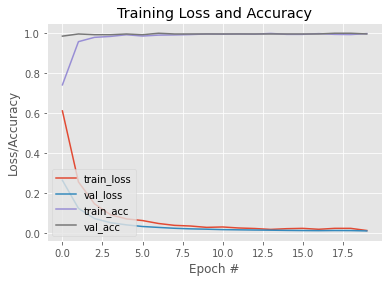

In [24]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")